In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
%matplotlib inline

In [246]:
#read in data
df_og = pd.read_csv("data/Aviation_Data.csv")
df = df_og.copy()

print(df.info(), '\n \n')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

C:\Users\Owner\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (6,7,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.9222,-81.8781,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


# Preliminary Formatting Change and Filtering

In [257]:
# Replaces "." with "_" in column names for ease of copy, paste
df.columns = df.columns.str.replace('.', "_")

# Extracting year from Event Date to assess how data changes by year
df['Year'] = [str(year).split('-')[0] for year in df['Event_Date']]

# Filtering dataframe to only show entries in Aircraft_Category that are Airplane
df = df.loc[df['Aircraft_Category'] == 'Airplane']

# The company will utilize professionally built planes. To best understand risk associated wiht professionally
# built planes, amateur-built will be removed from the dataset.
df = df.loc[df['Amateur_Built'] == 'No']

# Filtering dataframe to only show entries that have a Year 2000 as there were stricter air regulations enforced after 9/11
# and it makes sense to only show data around 20 years back from our problem
df = df.loc[df['Year'].astype(int) > 2000]

#Filtering out entries from Purpose_of_flight that arent one of 7 categories(Personal, Business, Executive/Corporate,
#Public Aircraft - Federal, Public Aircraft - State, Public Aircraft - Local or Public Aircraft)
#This is because we are looking to find an aircraft specifically for commercial and private activities
df = df.loc[df['Purpose_of_flight'].isin(['Personal','Business', 'Executive/corporate', 'Public Aircraft - Federal', 
                                          'Public Aircraft - State', 'Public Aircraft - Local', 'Public Aircraft'])]

# There are 1,825 rows where Investigation Type = 0. These entries have either null or 0 in all columns. Filtering out those.
df = df.loc[df['Investigation_Type'] != 0]


# # Same Makes showing up as different because of capitalization. Changing all Makes and Model to Title case
df["Make"] = [make.title() for make in df['Make']]
df['Model'] = [str(model).title() for model in df['Model']]

# # For Weather Condition, unknown is represented by "Unk" and "UNK". Converting them both to "Unknown".
df = df.replace(('Unk', 'UNK'), 'Unknown')

# # Replacing NaN with 0 for all injury data
df["Total_Fatal_Injuries"].fillna(0, inplace=True)
df["Total_Serious_Injuries"].fillna(0, inplace=True)
df["Total_Minor_Injuries"].fillna(0, inplace=True)
df["Total_Uninjured"].fillna(0, inplace=True)

print(df.info(), '\n \n')

#df.to_csv("data/Output_Data.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12380 entries, 49949 to 90345
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event_Id                12380 non-null  object 
 1   Investigation_Type      12380 non-null  object 
 2   Accident_Number         12380 non-null  object 
 3   Event_Date              12380 non-null  object 
 4   Location                12379 non-null  object 
 5   Country                 12380 non-null  object 
 6   Latitude                12264 non-null  object 
 7   Longitude               12259 non-null  object 
 8   Airport_Code            9000 non-null   object 
 9   Airport_Name            8995 non-null   object 
 10  Injury_Severity         12365 non-null  object 
 11  Aircraft_damage         12318 non-null  object 
 12  Aircraft_Category       12380 non-null  object 
 13  Registration_Number     12349 non-null  object 
 14  Make                    12380 non-

In [193]:
for i in range(len(df.columns)):
    print(df.iloc[:, i].value_counts(), '\n', '\n', '----------------------------------------\n')

20220608105217    2
20220808105682    2
20220111104514    2
20220212104630    2
20220822105776    2
                 ..
20180712X51213    1
20220629105392    1
20190917X81400    1
20200804X73007    1
20090422X61014    1
Name: Event_Id, Length: 12372, dtype: int64 
 
 ----------------------------------------

Accident    12264
Incident      116
Name: Investigation_Type, dtype: int64 
 
 ----------------------------------------

ERA22LA379    2
CEN22LA149    2
WPR22LA201    2
ERA22LA364    2
ERA22LA119    2
             ..
WPR14CA401    1
ERA19LA065    1
WPR11CA419    1
ANC13LA102    1
WPR19LA063    1
Name: Accident_Number, Length: 12373, dtype: int64 
 
 ----------------------------------------

2008-08-02    10
2007-10-07    10
2011-07-23    10
2008-06-29    10
2022-07-15    10
              ..
2012-01-16     1
2006-02-24     1
2020-03-18     1
2020-03-31     1
2012-04-05     1
Name: Event_Date, Length: 5445, dtype: int64 
 
 ----------------------------------------

Anchorage, AK     

In [194]:
df.loc[df['Investigation_Type'] == 0]

,Event_Id,Investigation_Type,Accident_Number,Event_Date,Location,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Air_carrier,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_phase_of_flight,Report_Status,Publication_Date,Year


In [70]:
df.loc[df['Year'] == '1982']

,Event_Id,Investigation_Type,Accident_Number,Event_Date,Location,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Air_carrier,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_phase_of_flight,Report_Status,Publication_Date,Year
7,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,NaN,NaN,NaN,BLACKBURN AG STRIP,...,NaN,0.0,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,01-01-1982,1982
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,NaN,NaN,N58,HANOVER,...,NaN,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,01-01-1982,1982
12,20020917X02148,Accident,FTW82FRJ07,1982-01-02,"HOMER, LA",United States,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,1.0,0.0,IMC,Cruise,Probable Cause,02-01-1983,1982
13,20020917X02134,Accident,FTW82FRA14,1982-01-02,"HEARNE, TX",United States,NaN,NaN,T72,HEARNE MUNICIPAL,...,NaN,1.0,0.0,0.0,0.0,IMC,Takeoff,Probable Cause,02-01-1983,1982
14,20020917X02119,Accident,FTW82FPJ10,1982-01-02,"CHICKASHA, OK",United States,NaN,NaN,NaN,NaN,...,NaN,1.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,02-01-1983,1982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3589,20020917X04829,Accident,LAX83FVG07,1982-12-31,"CLEARLAKE, CA",United States,NaN,NaN,209,CLEARLAKE,...,NaN,1.0,3.0,0.0,0.0,VMC,Landing,Probable Cause,31-12-1983,1982
3590,20020917X04490,Accident,CHI83LA067,1982-12-31,"CASSVILLE, WI",United States,NaN,NaN,C74,CASSVILLE MUNI,...,NaN,0.0,0.0,0.0,5.0,VMC,Cruise,Probable Cause,31-12-1983,1982
3591,20020917X05024,Accident,MKC83LA049,1982-12-31,"OAKLEY, KS",United States,NaN,NaN,K74,OAKLEY MUNI,...,NaN,0.0,0.0,0.0,3.0,VMC,Landing,Probable Cause,31-12-1983,1982
3593,20020917X05022,Accident,MKC83LA047,1982-12-31,"KEARNEY, NE",United States,NaN,NaN,EAR,MUNICIPAL,...,NaN,0.0,0.0,1.0,3.0,VMC,Landing,Probable Cause,31-12-1983,1982


In [138]:
inv_years = df['Year']
inv_years_dist = inv_years.value_counts().sort_index()
inv_years_dist

2001     23
2002     38
2003    100
2004    284
2005    400
2006    416
2007    555
2008    814
2009    790
2010    823
2011    795
2012    783
2013    673
2014    644
2015    684
2016    695
2017    665
2018    657
2019    652
2020    595
2021    640
2022    654
Name: Year, dtype: int64

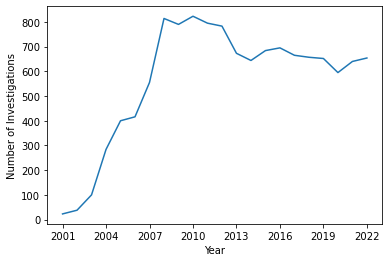

In [139]:
fig, ax = plt.subplots()

ax.plot(inv_years_dist.index, inv_years_dist.values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax.set_ylabel('Number of Investigations')
ax.set_xlabel("Year")
plt.show()

In [140]:
inv_years_acc = df.loc[df['Investigation_Type'] == 'Accident']['Year']
inv_years_dist_acc = inv_years_acc.value_counts().sort_index()

df_inv_type_acc = pd.DataFrame(inv_years_dist_acc).reset_index()
df_inv_type_acc.columns = ['Year', 'Accidents']

inv_years_inc = df.loc[df['Investigation_Type'] == 'Incident']['Year']
inv_years_dist_inc = inv_years_inc.value_counts().sort_index()

df_inv_type_inc = pd.DataFrame(inv_years_dist_inc).reset_index()
df_inv_type_inc.columns = ['Year', 'Incidents']

df_inv_type_merge = pd.merge(df_inv_type_acc, df_inv_type_inc, how = 'outer', on = 'Year')
df_inv_type_merge['Incidents'] = df_inv_type_merge['Incidents'].fillna(0)

df_inv_type_merge['Accidents_pct'] = df_inv_type_merge['Accidents'] / (df_inv_type_merge['Accidents'] + df_inv_type_merge['Incidents']) * 100
df_inv_type_merge['Incidents_pct'] = df_inv_type_merge['Incidents'] / (df_inv_type_merge['Accidents'] + df_inv_type_merge['Incidents']) * 100

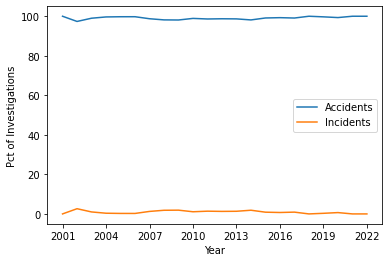

In [141]:
fig, ax = plt.subplots()

ax.plot(df_inv_type_merge['Year'], df_inv_type_merge['Accidents_pct'], label = 'Accidents')
ax.plot(df_inv_type_merge['Year'], df_inv_type_merge['Incidents_pct'], label = 'Incidents')

ax.legend()

ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax.set_ylabel('Pct of Investigations')
ax.set_xlabel("Year")
plt.show()

In [143]:
ap_dam_score = None

for index, row in df.iterrows():

    if row['Aircraft_damage'] == 'Destroyed':
        ap_dam_score = 10

    elif row['Aircraft_damage'] == 'Substantial':
        ap_dam_score = 5

    else:
        ap_dam_score = 1

    df.loc[index, 'harm'] = 20 * row['Total_Fatal_Injuries'] + 10 * row['Total_Serious_Injuries'] + 8 * row['Total_Minor_Injuries'] + ap_dam_score

df['harm'].value_counts().sort_index()

1.0       155
5.0      5820
9.0        21
10.0       47
11.0        2
         ... 
190.0       2
205.0       1
210.0       1
214.0       1
285.0       1
Name: harm, Length: 79, dtype: int64

In [ ]:
df.loc[df['harm'] == df['harm'].median()]['Make']

NameError: name 'make' is not defined

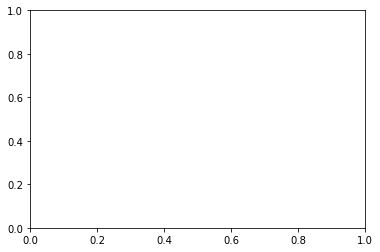

In [144]:
fig, ax = plt.subplots()

ax.hist(df[make.value], bins=50)


ax.set_ylabel('Number of Investigations')
ax.set_xlabel("Year")
plt.show()

In [ ]:
df.info()

In [ ]:
df['harm'].value_counts().sort_index()

C:\Users\Owner\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Owner\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


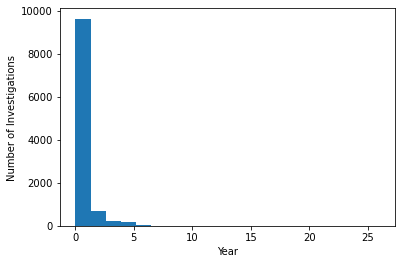

In [145]:
fig, ax = plt.subplots()

ax.hist(df['Total_Fatal_Injuries'], bins=20)


ax.set_ylabel('Number of Investigations')
ax.set_xlabel("Year")
plt.show()

In [ ]:
print(df['Total_Fatal_Injuries'].sum())
print(df['Total_Fatal_Injuries'].count())
print(df['Total_Fatal_Injuries'].value_counts())
print('\n')
print('1234')

df['Total_Fatal_Injuries'].value_counts().values.sum()


In [ ]:
df_test = pd.isnull(df.Total_Fatal_Injuries)
df_test

In [ ]:
df[df["Total_Fatal_Injuries"].isna()]